# Интерпретация прогнозов модели (SHAP) - объяснение поведения модели на отдельных наблюдениях#

### 1. Feature importance признаков

In [396]:
#!pip install shap

In [397]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, train_test_split
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import catboost
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import shap

shap.initjs()

In [424]:
df = pd.read_csv("agaricus-lepiota.data") #используем датасет грибы, в котором присутствуют только категориальные переменные и целевой переменной является ядовитый гриб или нет
print(df.shape)
df.head(10)

(8124, 23)


,classes,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [425]:
df.loc[df['classes']== 'p', 'classes'] = 1
df.loc[df['classes']== 'e', 'classes'] = 0
df['classes'] = df['classes'].astype(int)
df['classes'].value_counts()

0    4208
1    3916
Name: classes, dtype: int64

In [426]:
X = df.drop('classes', axis = 1)
y = df['classes']
cat_features = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']

In [427]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [428]:
#pipeline
class CatFeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]
    

classifier = Pipeline([
    ('catfeatures', CatFeaturesSelector(cat_features)),
    ('classifier', CatBoostClassifier(random_state = 42, cat_features = cat_features))
])

Модель - catboost

In [429]:
#обучение пайплайна
classifier.fit(X_train, y_train)

Learning rate set to 0.022287
0:	learn: 0.6410732	total: 2.99ms	remaining: 2.98s
1:	learn: 0.5920969	total: 6.38ms	remaining: 3.19s
2:	learn: 0.5418579	total: 9.57ms	remaining: 3.18s
3:	learn: 0.4947208	total: 15.5ms	remaining: 3.86s
4:	learn: 0.4479437	total: 20.8ms	remaining: 4.13s
5:	learn: 0.4128656	total: 24.6ms	remaining: 4.08s
6:	learn: 0.3807262	total: 28.1ms	remaining: 3.99s
7:	learn: 0.3516865	total: 31.2ms	remaining: 3.86s
8:	learn: 0.3270496	total: 34.4ms	remaining: 3.78s
9:	learn: 0.3043793	total: 37.8ms	remaining: 3.74s
10:	learn: 0.2777046	total: 42.7ms	remaining: 3.84s
11:	learn: 0.2589411	total: 46.6ms	remaining: 3.83s
12:	learn: 0.2423441	total: 49.5ms	remaining: 3.76s
13:	learn: 0.2275524	total: 53.2ms	remaining: 3.74s
14:	learn: 0.2083961	total: 58.7ms	remaining: 3.86s
15:	learn: 0.1864441	total: 63.8ms	remaining: 3.92s
16:	learn: 0.1669339	total: 69.5ms	remaining: 4.02s
17:	learn: 0.1499582	total: 74.3ms	remaining: 4.05s
18:	learn: 0.1386028	total: 78.9ms	remaining

176:	learn: 0.0027634	total: 999ms	remaining: 4.65s
177:	learn: 0.0027122	total: 1s	remaining: 4.64s
178:	learn: 0.0027122	total: 1.01s	remaining: 4.64s
179:	learn: 0.0026925	total: 1.02s	remaining: 4.64s
180:	learn: 0.0026717	total: 1.02s	remaining: 4.64s
181:	learn: 0.0026717	total: 1.03s	remaining: 4.63s
182:	learn: 0.0026598	total: 1.04s	remaining: 4.63s
183:	learn: 0.0026477	total: 1.04s	remaining: 4.63s
184:	learn: 0.0026375	total: 1.05s	remaining: 4.62s
185:	learn: 0.0025740	total: 1.05s	remaining: 4.62s
186:	learn: 0.0025688	total: 1.06s	remaining: 4.61s
187:	learn: 0.0025688	total: 1.06s	remaining: 4.6s
188:	learn: 0.0025602	total: 1.07s	remaining: 4.6s
189:	learn: 0.0025396	total: 1.08s	remaining: 4.59s
190:	learn: 0.0025285	total: 1.08s	remaining: 4.59s
191:	learn: 0.0025285	total: 1.09s	remaining: 4.59s
192:	learn: 0.0025007	total: 1.09s	remaining: 4.58s
193:	learn: 0.0025007	total: 1.1s	remaining: 4.57s
194:	learn: 0.0024684	total: 1.11s	remaining: 4.57s
195:	learn: 0.0024

344:	learn: 0.0012124	total: 2s	remaining: 3.8s
345:	learn: 0.0012124	total: 2.01s	remaining: 3.79s
346:	learn: 0.0012124	total: 2.01s	remaining: 3.79s
347:	learn: 0.0012019	total: 2.02s	remaining: 3.79s
348:	learn: 0.0011924	total: 2.03s	remaining: 3.78s
349:	learn: 0.0011862	total: 2.04s	remaining: 3.78s
350:	learn: 0.0011852	total: 2.04s	remaining: 3.77s
351:	learn: 0.0011852	total: 2.04s	remaining: 3.77s
352:	learn: 0.0011852	total: 2.05s	remaining: 3.76s
353:	learn: 0.0011852	total: 2.06s	remaining: 3.75s
354:	learn: 0.0011852	total: 2.06s	remaining: 3.75s
355:	learn: 0.0011852	total: 2.07s	remaining: 3.74s
356:	learn: 0.0011827	total: 2.07s	remaining: 3.73s
357:	learn: 0.0011827	total: 2.08s	remaining: 3.73s
358:	learn: 0.0011746	total: 2.09s	remaining: 3.73s
359:	learn: 0.0011688	total: 2.09s	remaining: 3.72s
360:	learn: 0.0011688	total: 2.1s	remaining: 3.71s
361:	learn: 0.0011596	total: 2.1s	remaining: 3.71s
362:	learn: 0.0011596	total: 2.11s	remaining: 3.7s
363:	learn: 0.00115

515:	learn: 0.0008847	total: 3s	remaining: 2.82s
516:	learn: 0.0008847	total: 3.01s	remaining: 2.81s
517:	learn: 0.0008847	total: 3.02s	remaining: 2.81s
518:	learn: 0.0008847	total: 3.02s	remaining: 2.8s
519:	learn: 0.0008786	total: 3.03s	remaining: 2.8s
520:	learn: 0.0008786	total: 3.03s	remaining: 2.79s
521:	learn: 0.0008786	total: 3.04s	remaining: 2.78s
522:	learn: 0.0008786	total: 3.04s	remaining: 2.78s
523:	learn: 0.0008786	total: 3.05s	remaining: 2.77s
524:	learn: 0.0008786	total: 3.06s	remaining: 2.77s
525:	learn: 0.0008786	total: 3.06s	remaining: 2.76s
526:	learn: 0.0008786	total: 3.07s	remaining: 2.75s
527:	learn: 0.0008786	total: 3.07s	remaining: 2.75s
528:	learn: 0.0008786	total: 3.08s	remaining: 2.74s
529:	learn: 0.0008786	total: 3.08s	remaining: 2.73s
530:	learn: 0.0008785	total: 3.09s	remaining: 2.73s
531:	learn: 0.0008785	total: 3.1s	remaining: 2.72s
532:	learn: 0.0008785	total: 3.1s	remaining: 2.72s
533:	learn: 0.0008700	total: 3.11s	remaining: 2.71s
534:	learn: 0.00087

689:	learn: 0.0008324	total: 4s	remaining: 1.8s
690:	learn: 0.0008324	total: 4s	remaining: 1.79s
691:	learn: 0.0008324	total: 4.01s	remaining: 1.78s
692:	learn: 0.0008324	total: 4.02s	remaining: 1.78s
693:	learn: 0.0008324	total: 4.03s	remaining: 1.77s
694:	learn: 0.0008324	total: 4.03s	remaining: 1.77s
695:	learn: 0.0008324	total: 4.04s	remaining: 1.76s
696:	learn: 0.0008324	total: 4.04s	remaining: 1.76s
697:	learn: 0.0008324	total: 4.05s	remaining: 1.75s
698:	learn: 0.0008324	total: 4.05s	remaining: 1.75s
699:	learn: 0.0008324	total: 4.06s	remaining: 1.74s
700:	learn: 0.0008324	total: 4.07s	remaining: 1.73s
701:	learn: 0.0008324	total: 4.07s	remaining: 1.73s
702:	learn: 0.0008324	total: 4.08s	remaining: 1.72s
703:	learn: 0.0008324	total: 4.08s	remaining: 1.72s
704:	learn: 0.0008324	total: 4.09s	remaining: 1.71s
705:	learn: 0.0008324	total: 4.09s	remaining: 1.71s
706:	learn: 0.0008324	total: 4.1s	remaining: 1.7s
707:	learn: 0.0008324	total: 4.11s	remaining: 1.69s
708:	learn: 0.0008324

863:	learn: 0.0008322	total: 5s	remaining: 787ms
864:	learn: 0.0008322	total: 5s	remaining: 781ms
865:	learn: 0.0008322	total: 5.01s	remaining: 775ms
866:	learn: 0.0008322	total: 5.01s	remaining: 769ms
867:	learn: 0.0008322	total: 5.02s	remaining: 764ms
868:	learn: 0.0008322	total: 5.03s	remaining: 758ms
869:	learn: 0.0008322	total: 5.03s	remaining: 752ms
870:	learn: 0.0008322	total: 5.04s	remaining: 746ms
871:	learn: 0.0008322	total: 5.04s	remaining: 740ms
872:	learn: 0.0008322	total: 5.05s	remaining: 735ms
873:	learn: 0.0008322	total: 5.05s	remaining: 729ms
874:	learn: 0.0008322	total: 5.06s	remaining: 723ms
875:	learn: 0.0008322	total: 5.07s	remaining: 717ms
876:	learn: 0.0008322	total: 5.07s	remaining: 711ms
877:	learn: 0.0008322	total: 5.08s	remaining: 706ms
878:	learn: 0.0008322	total: 5.08s	remaining: 700ms
879:	learn: 0.0008322	total: 5.09s	remaining: 694ms
880:	learn: 0.0008322	total: 5.09s	remaining: 688ms
881:	learn: 0.0008322	total: 5.1s	remaining: 682ms
882:	learn: 0.00083

Pipeline(steps=[('catfeatures',
                 CatFeaturesSelector(columns=['cap-shape', 'cap-surface',
                                              'cap-color', 'bruises', 'odor',
                                              'gill-attachment', 'gill-spacing',
                                              'gill-size', 'gill-color',
                                              'stalk-shape', 'stalk-root',
                                              'stalk-surface-above-ring',
                                              'stalk-surface-below-ring',
                                              'stalk-color-above-ring',
                                              'stalk-color-below-ring',
                                              'veil-type', 'veil-color',
                                              'ring-number', 'ring-type',
                                              'spore-print-color', 'population',
                                              'habitat'])),
       

In [430]:
preds =  classifier.predict_proba(X_test)[:, 1]
 
precision, recall, thresholds = precision_recall_curve(y_test, preds)

roc = roc_auc_score(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.983740, F-Score=1.000, Precision=1.000, Recall=1.000


### Посмотрим важность признаков

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


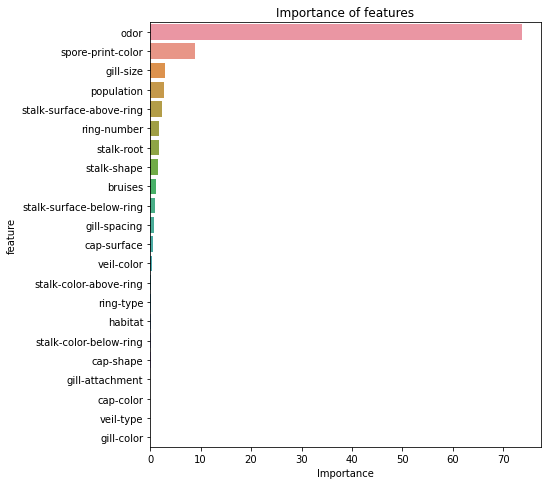

In [431]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (7, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()


importances = classifier.steps[1][1].feature_importances_    
show_feature_importances(cat_features, importances, get_top=None)

1. Самым важным признаком для определения, ядовитый гриб или нет, для модели catboost оказался запах (odor), он более, чем на 70% определяет, ядовитый гриб или нет.
2. Вторым по важности признаком является цвет и рисунок спор (spore-print-color)
3. Третим по важность является размер гимениальной пластинки (gill-size)
Также достаточно важными являются population, stalk-surface-above-ring, ring-number, stalk-root, stalk-shape, bruises. 
Остальные признаки оказывают влияние, но оно уже не так значительно

In [432]:
# explain the model's predictions using SHAP
model = classifier.steps[1][1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

На данной схеме также видно, что самый значительный признак - запах (odor)

Посмотрим на summary_plot. Значений признаков у нас нет, так как весь датасет категориальный, но с учетом onehotencoding, который сделан catboost самостоятельно, мы можем видеть степень влияния каждого признака на целевую переменную.

In [433]:
shap_values

array([[-9.16494527e-03,  6.23670358e-02,  8.28319005e-04, ...,
         1.11209519e+00,  1.19034421e-01,  8.04657700e-03],
       [-1.73570389e-02, -6.54258125e-02, -3.78941470e-04, ...,
        -1.16997951e+00, -1.42756622e-01, -3.91515942e-03],
       [-2.43903632e-02, -4.29551637e-02, -3.85475620e-04, ...,
        -1.11486483e+00, -8.56891002e-01, -1.55955239e-02],
       ...,
       [-1.39657054e-02, -2.93491544e-02, -3.18371111e-04, ...,
        -1.15798358e+00, -8.61289807e-02, -4.17358890e-04],
       [-8.73168993e-03, -5.85202322e-02, -3.48548710e-04, ...,
        -1.27340278e+00,  8.09085828e-02, -2.01525827e-02],
       [-9.76983857e-03,  3.84932695e-03, -4.15707581e-04, ...,
        -1.19914875e+00, -1.16533580e-01, -1.98789756e-02]])

In [434]:
X_train.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
5832,f,y,y,f,f,f,c,b,p,e,...,k,b,n,p,w,o,l,h,y,g
601,x,y,n,t,l,f,c,b,w,e,...,y,w,w,p,w,o,p,n,y,g
1601,f,s,g,f,n,f,w,b,k,t,...,f,w,w,p,w,o,e,k,a,g
4941,x,f,g,f,f,f,c,b,g,e,...,k,b,p,p,w,o,l,h,v,p
7492,f,y,n,f,f,f,c,n,b,t,...,k,p,w,p,w,o,e,w,v,d


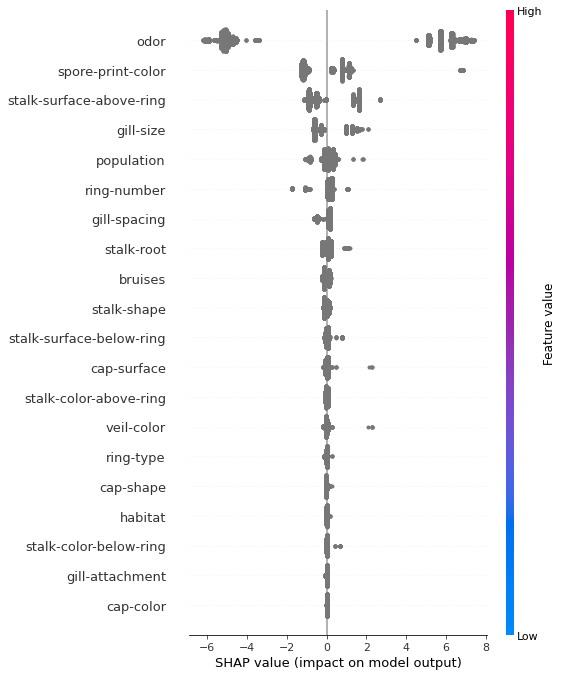

In [435]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

На графике выше отчетливо видно, какие признаки разделяют данные на два класса практически полностью - это те признаки, в которых облака скопления точек не соединяются и не создают облако скопления в районе центральной линии (линии смены класса). Это признаки odor, spore-print-color, stalk-surface-above-ring, gull-size. Остальные признаки не обладают такой разделяющей способностью. Но и этих признаков достаточно, чтобы модель показывала практически идеалmный результат (даже без отладки модели по гипер-параметрам).

Самый важный из признаков - запах. Если можно оценить данный вид гриба по запаху (присвоить один из типов запахов: almond, anise, creosote, fishy, foul, musty, none, pungent, spicy), то практически сразу можно с большей степенью вероятности определить, ядовитый данный гриб или нет.

### Cредние значения SHAP для каждого признака

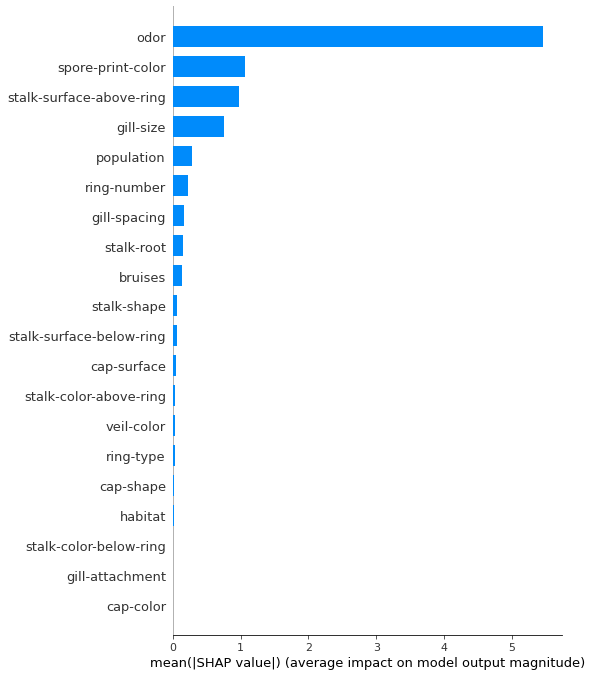

In [436]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Построим force_plot для отдельных наблюдений и посмотрим важность признаков

In [437]:
shap.force_plot(explainer.expected_value, shap_values[3,:], X_train.iloc[3,:])

In [438]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])

In [439]:
shap.force_plot(explainer.expected_value, shap_values[1000,:], X_train.iloc[1000,:])

In [440]:
shap.force_plot(explainer.expected_value, shap_values[3000,:], X_train.iloc[3000,:])

In [441]:
shap.force_plot(explainer.expected_value, shap_values[3457,:], X_train.iloc[3457,:])

Мы видим, что признаки подобраны настолько грамотно, что модель обладает 100% разделяющей способностью. Классы четко разграничены. Самый важный признак для отдельных образцов - запах (odor).

### Посмотрим summary_plot для топ 10%:

In [442]:
preds_train =  pd.DataFrame(classifier.predict_proba(X_train)[:, 1], columns = ['pred_proba'])
shap_values = pd.DataFrame(explainer.shap_values(X_train), columns = cat_features)
X_train = X_train.reset_index(drop=True)
preds_train = preds_train.reset_index(drop=True)
pred_proba_train_shap = pd.concat([preds_train, shap_values], axis=1)
pred_proba_X_train = pd.concat([preds_train, X_train], axis=1)
pred_proba_train_shap.sort_values('pred_proba', axis=0, inplace=True, ascending=False)
pred_proba_X_train.sort_values('pred_proba', axis=0, inplace=True, ascending=False)

In [443]:
pred_proba_X_train_10percent = pred_proba_X_train.iloc[0:round((pred_proba_X_train.shape[0]/10)),:].drop('pred_proba', axis = 1)

In [444]:
pred_proba_train_shap_10percent = pred_proba_train_shap.iloc[0:round((pred_proba_train_shap.shape[0]/10)),:].drop('pred_proba', axis = 1)

In [445]:
pred_proba_X_train_10percent.shape

(609, 22)

In [446]:
pred_proba_X_train_10percent.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4265,k,s,e,f,s,f,c,n,b,t,...,k,p,w,p,w,o,e,w,v,d
3361,k,s,e,f,f,f,c,n,b,t,...,k,p,w,p,w,o,e,w,v,d
3858,k,s,e,f,f,f,c,n,b,t,...,k,p,p,p,w,o,e,w,v,d
2446,k,s,e,f,s,f,c,n,b,t,...,k,p,p,p,w,o,e,w,v,d
1307,k,s,n,f,f,f,c,n,b,t,...,k,p,w,p,w,o,e,w,v,d


In [447]:
pred_proba_train_shap_10percent.shape

(609, 22)

In [448]:
pred_proba_train_shap_10percent.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4265,0.024312,0.040234,0.000885,0.166593,5.130956,0.001476,0.150586,0.959115,0.0,-0.035628,...,0.082161,0.042452,-0.000661,0.0,0.035616,0.247267,0.021133,0.783604,0.440884,0.009776
3361,0.024312,0.040234,0.000885,0.166593,5.130956,0.001476,0.150586,0.959115,0.0,-0.035628,...,0.082161,0.042452,-0.000661,0.0,0.035616,0.247267,0.021133,0.783604,0.440884,0.009776
3858,0.024312,0.040234,0.000885,0.166593,5.130956,0.001476,0.150586,0.959115,0.0,-0.035628,...,0.082161,0.042452,-0.000666,0.0,0.035616,0.247267,0.021133,0.783604,0.440884,0.009776
2446,0.024312,0.040234,0.000885,0.166593,5.130956,0.001476,0.150586,0.959115,0.0,-0.035628,...,0.082161,0.042452,-0.000666,0.0,0.035616,0.247267,0.021133,0.783604,0.440884,0.009776
1307,0.024312,0.040234,0.000869,0.166593,5.130956,0.001476,0.150586,0.959115,0.0,-0.035628,...,0.082161,0.042451,-0.000661,0.0,0.035616,0.247267,0.021133,0.783604,0.440884,0.009776


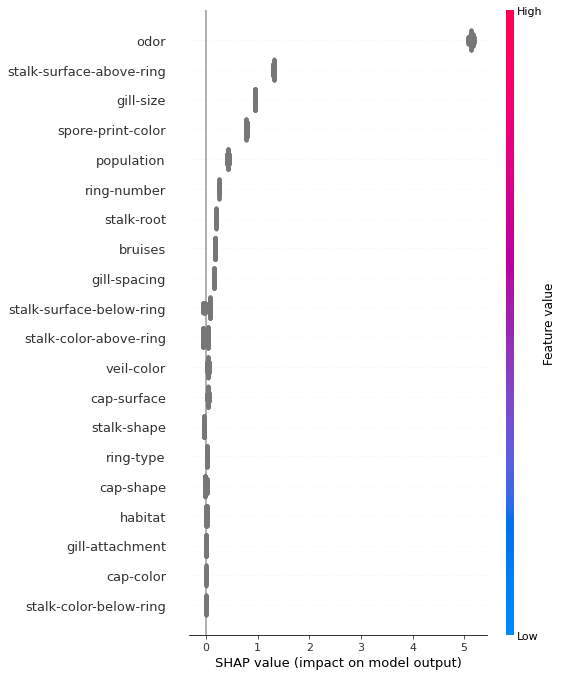

In [449]:
# summarize the effects of all the features 10% max train_pred_proba

shap.summary_plot(np.array(pred_proba_train_shap_10percent), pred_proba_X_train_10percent)

Цветовая шкала для нас на данном графике значения не имеет, так как все признаки категориальные и catboost их кодирует onehot encoding в бинарном варианте.

Вывод: для 10% выборки грибов, которые с самой высокой степенью вероятности являются ядовитыми по прогнозам модели catboost (фактический класс совпадает с предсказаниями модели на 100%), явно видны признаки, которые оказывают самое сильное воздействие на определение класса ядовитых грибов - это odor (запах, это самый существенный признак), stalk-surface-above-ring, gill-size, spore-print-color, population, ring-number, stalk-root, bruises, gill-spacing. Остальные признаки могут быть одинаково выражены у обоих классов грибов.